<div style="background-color: #ffff4d; color: black; font-size: 30px; padding: 10px;">
  <strong>Quantitative Analysis and Predictive Modeling of Concrete Strength Based on Composition</strong>
</div>

<div style="color:black;background-color: #ffffcc;">
  
  # **Goals:**</div>
<div style="color:black; font-size:20px;">
  
</strong> 

- The primary goal is to investigate the relationships between the various components of concrete and its resulting strength.
- A secondary goal is to create a predictive model that can accurately forecast the strength of concrete based on its material composition.
  </strong></div>

<div style="color:black; background-color: #ffffcc;">
  
  # **Imports:**</div>

In [1]:
#tabular data imports :
import pandas as pd
import numpy as np
import env
from env import username, password, host
from pydataset import data

# visualization imports:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
#stats
import scipy.stats as stats
from scipy.stats import spearmanr

import warnings
warnings.filterwarnings("ignore")
import explore as e
import wrangle as w

<div style="color:black;background-color: #ffffcc;">
  
  # Data Dictionary</div>

| Feature       | Definition                                 |
|---------------|--------------------------------------------|
| cement        | Quantity of cement in the sample mix (yd³)  |
| slag          | Quantity of slag in the samplemix (yd³)    |
| ash           | Quantity of fly ash in the samplemix (yd³) |
| water         | Quantity of water in the sample mix (yd³)   |
| superplastic  | Quantity of superplasticizer in the sample mix (yd³)   |
| coarseagg     | Quantity of coarse aggregates in the sample mix (yd³)  |
| fineagg       | Quantity of fine aggregates in the sample mix (yd³)    |
| age           | Age of concrete at testing (days)          |
| strength      | Compressive strength of concrete (psi)     |
| total_lbs_per_yd³ | Total weight of all components per cubic yard (yd³) |
| sample        | Identifier for the concrete sample         |


<div style="color:black;background-color: #ffffcc;">
  
  # **Acquire:**</div>
<div style="color:black; font-size:20px;">
  
</strong> 

- Data was gathered during the Tobias cohort from the url: 
    * 'https://www.kaggle.com/datasets/vinayakshanawad/cement-manufacturing-concrete-dataset'
- Original size of data (1030 rows, 9 columns)
- Each row represents a concrete sample
- Each column represents a feature for each concrete sample

  </strong></div>

In [2]:
# turning the .csv into a pandas df and taking a peek
concrete = pd.read_csv('concrete.csv')
concrete.head(3)

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22


In [3]:
# finding count, nulls, dtype, column comprehension
concrete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cement        1030 non-null   float64
 1   slag          1030 non-null   float64
 2   ash           1030 non-null   float64
 3   water         1030 non-null   float64
 4   superplastic  1030 non-null   float64
 5   coarseagg     1030 non-null   float64
 6   fineagg       1030 non-null   float64
 7   age           1030 non-null   int64  
 8   strength      1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.6 KB


<div style="color:black; background-color: #ffffcc;">
  
  # **Prepare**</div>

- Created an index 'sample' to associate each row of data as an id

- Feature engineered column 'total_lbs_per_yd^3' which sums the weights of all materials in the sample of a cubic yard.

In [4]:
# calling the prepared data through a function
df = w.prepared_concrete_data(concrete)
df.head(3)

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength,total_lbs_per_yd^3
sample,,,,,,,,,,
0,311.512806,467.379440,0.000000,448.640170,0.000000,2142.449716,1650.158070,28,4335.18582,5020.0
1,372.360318,93.034964,274.034266,348.991346,23.809896,2382.753296,1755.318444,14,3409.84338,5250.0
2,551.155000,0.000000,210.982134,413.145788,12.125410,2109.600878,1898.618744,28,4238.01036,5196.0


In [5]:
# statistical observation of all columns
df.describe().T

,count,mean,std,min,25%,50%,75%,max
cement,1030.0,619.868297,230.396821,224.871240,424.113772,601.640798,771.617000,1190.494800
slag,1030.0,162.912214,190.213162,0.000000,0.000000,48.501640,315.150429,792.340428
ash,1030.0,119.464719,141.089075,0.000000,0.000000,0.000000,260.806546,441.144462
water,1030.0,400.286860,47.077937,268.522716,363.541838,407.854700,423.287040,544.541140
superplastic,1030.0,13.678918,13.170050,0.000000,0.000000,14.109568,22.487124,70.988764
coarseagg,1030.0,2144.916536,171.417922,1765.900620,2054.705840,2134.072160,2269.435828,2524.289900
fineagg,1030.0,1705.451010,176.757569,1309.544280,1611.466989,1718.501290,1816.606880,2188.305812
age,1030.0,45.662136,63.169912,1.000000,7.000000,28.000000,56.000000,365.000000
strength,1030.0,5194.965451,2422.967403,337.938540,3438.850980,4995.833910,6691.328130,11980.138800
total_lbs_per_yd^3,1030.0,5166.579612,144.095702,4838.000000,5051.250000,5179.000000,5270.000000,5624.000000


In [6]:
# finding count, nulls, dtype, column comprehension again
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1030 entries, 0 to 1029
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   cement              1030 non-null   float64
 1   slag                1030 non-null   float64
 2   ash                 1030 non-null   float64
 3   water               1030 non-null   float64
 4   superplastic        1030 non-null   float64
 5   coarseagg           1030 non-null   float64
 6   fineagg             1030 non-null   float64
 7   age                 1030 non-null   int64  
 8   strength            1030 non-null   float64
 9   total_lbs_per_yd^3  1030 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 88.5 KB


In [7]:
# checking for possible categorical features
df.nunique() 

cement                278
slag                  185
ash                   156
water                 195
superplastic          111
coarseagg             284
fineagg               302
age                    14
strength              845
total_lbs_per_yd^3    255
dtype: int64

<div style="color:black; background-color: #ffffcc;">
  
# **Explore**
## Univariate:
</div>

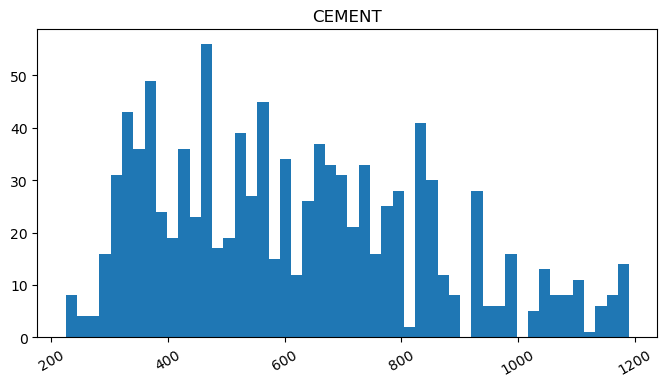

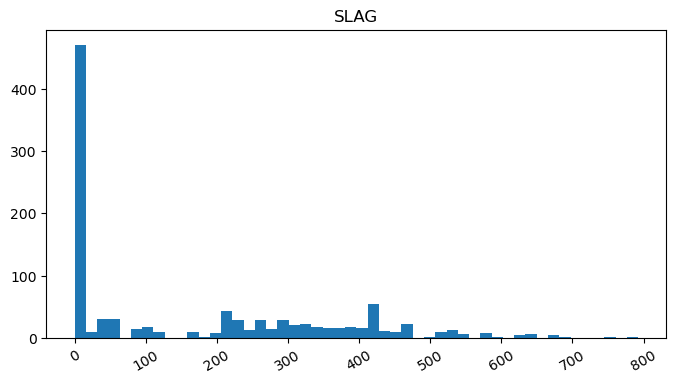

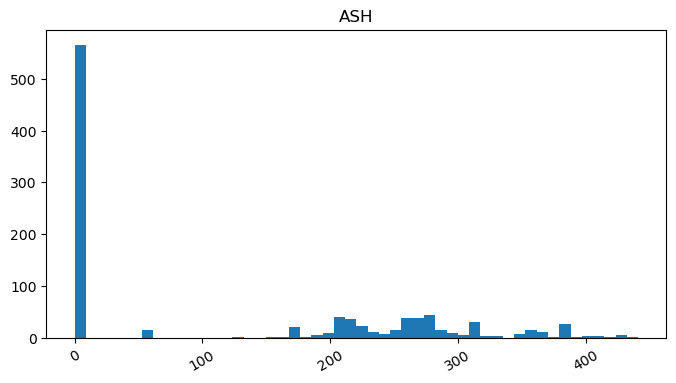

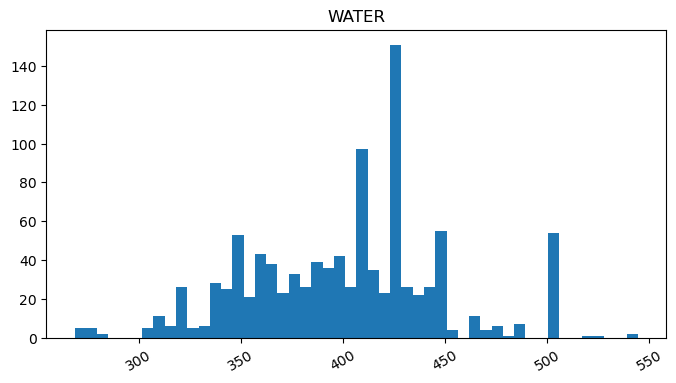

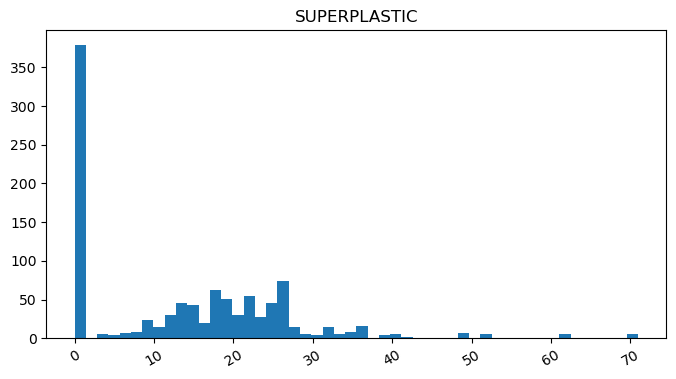

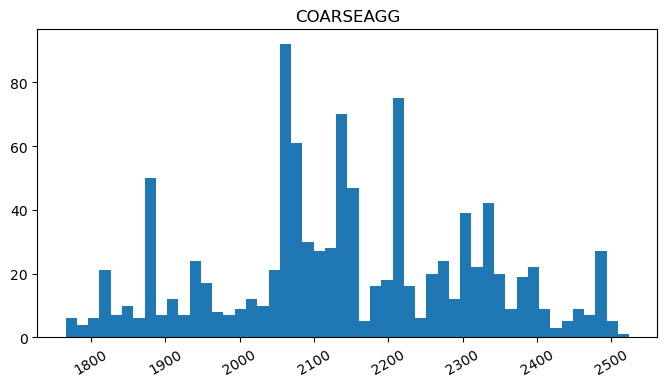

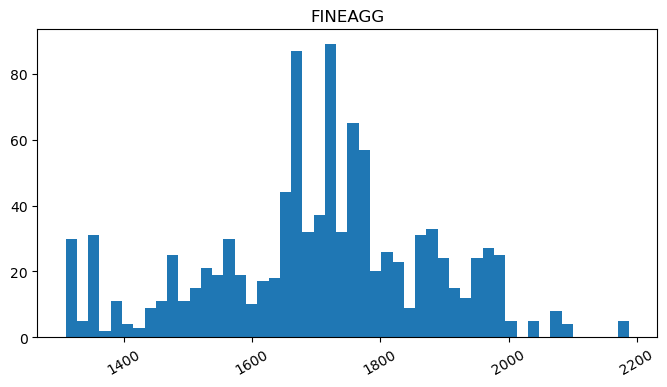

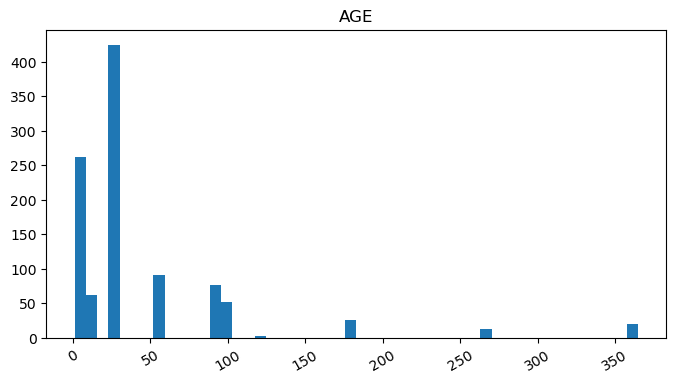

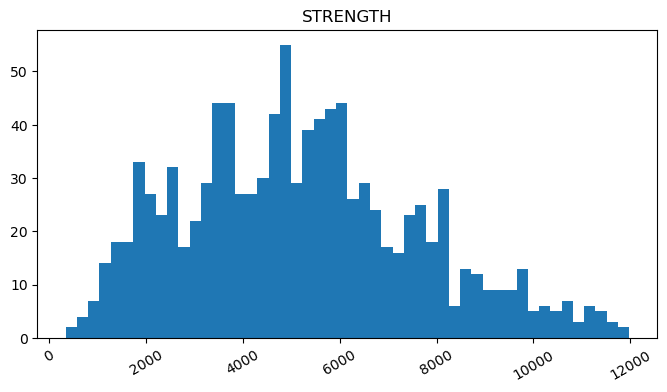

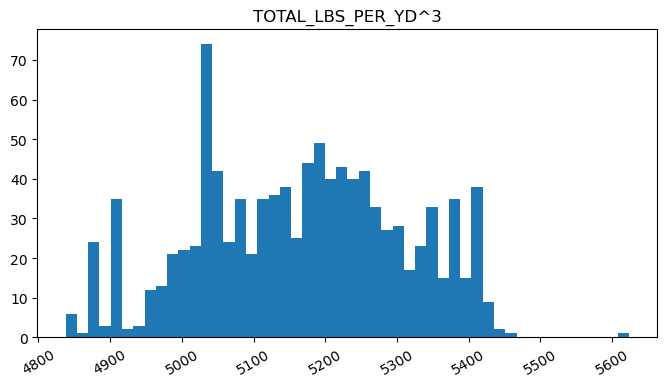

In [8]:
# histogram of ALL data for each feature
e.plot_all_histograms(df)


<div style="color:black; background-color: #ffffcc;">
  
# **Split**
</div>

In [9]:
# splitting the data, result will print out the shape of each group
train, validate, test = e.split_data(df)


    train -> (618, 10)
    validate -> (206, 10)
    test -> (206, 10)


In [10]:
# taking a quick peek into train
train.head(3)

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength,total_lbs_per_yd^3
sample,,,,,,,,,,
600,610.67974,0.0000,0.00000,421.08242,0.000000,2134.07216,1887.15472,3,1647.63168,5053.0
160,729.72922,0.0000,0.00000,423.28704,0.000000,2156.11836,1818.81150,28,4561.44510,5128.0
854,853.18794,44.0924,207.23428,346.12534,25.573592,2067.93356,1862.90390,3,5042.97126,5407.0


<div style="color:black; background-color: #ffffcc;">
  
## Checking 'strength' for normality
</div>

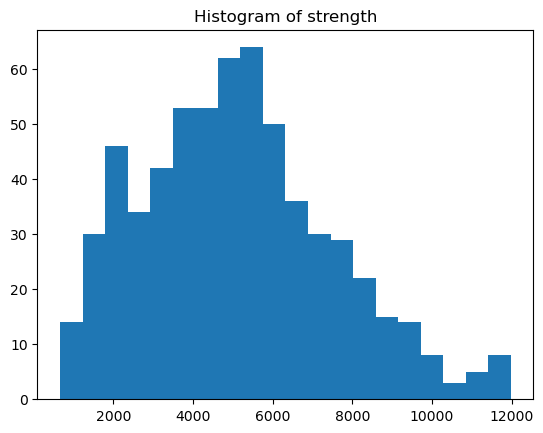

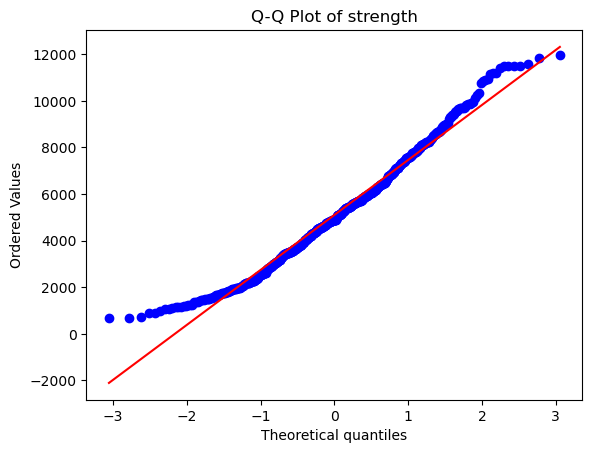

Shapiro-Wilk Test for strength: Statistic=0.978, p-value=0.000
D’Agostino’s K^2 Test for strength: Statistic=20.799, p-value=0.000
Anderson-Darling Test for strength: Statistic=2.376
15.000: 0.572, data does not look normal (reject H0)
10.000: 0.652, data does not look normal (reject H0)
5.000: 0.782, data does not look normal (reject H0)
2.500: 0.912, data does not look normal (reject H0)
1.000: 1.085, data does not look normal (reject H0)


In [11]:
# checking for normality visually and with statistical tests 
e.check_normality(train, 'strength')

<div style="color:black; background-color: #ffffcc;">
  
# **Explore**
## Scaling & Multi-variate
</div>

In [12]:
# splitting and scaling: printing out the shape of each group
train_scaled, validate_scaled, test_scaled = e.preprocess_concrete(df)
train_scaled.head(3)


    train -> (618, 10)
    validate -> (206, 10)
    test -> (206, 10)


,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,total_lbs_per_yd^3,strength
sample,,,,,,,,,,
600,0.399543,0.000000,0.000000,0.552716,0.000000,0.501050,0.657301,0.005495,0.3440,1647.63168
160,0.522831,0.000000,0.000000,0.560703,0.000000,0.531053,0.579528,0.074176,0.4640,4561.44510
854,0.650685,0.055648,0.469765,0.281150,0.360248,0.411041,0.629704,0.005495,0.9104,5042.97126


<div style="color:black; background-color: #ffffcc;">
    
  # Hypotheses:
</div>

### Q1. Is there a relationship between cement [content] and strength?

- *both of my variables are **continuous***

- check for correlation

- alpha = 0.05

$H_0$ : There is no linear correlation between cement and strength

$H_a$ : There is a linear correlation between cement and strength

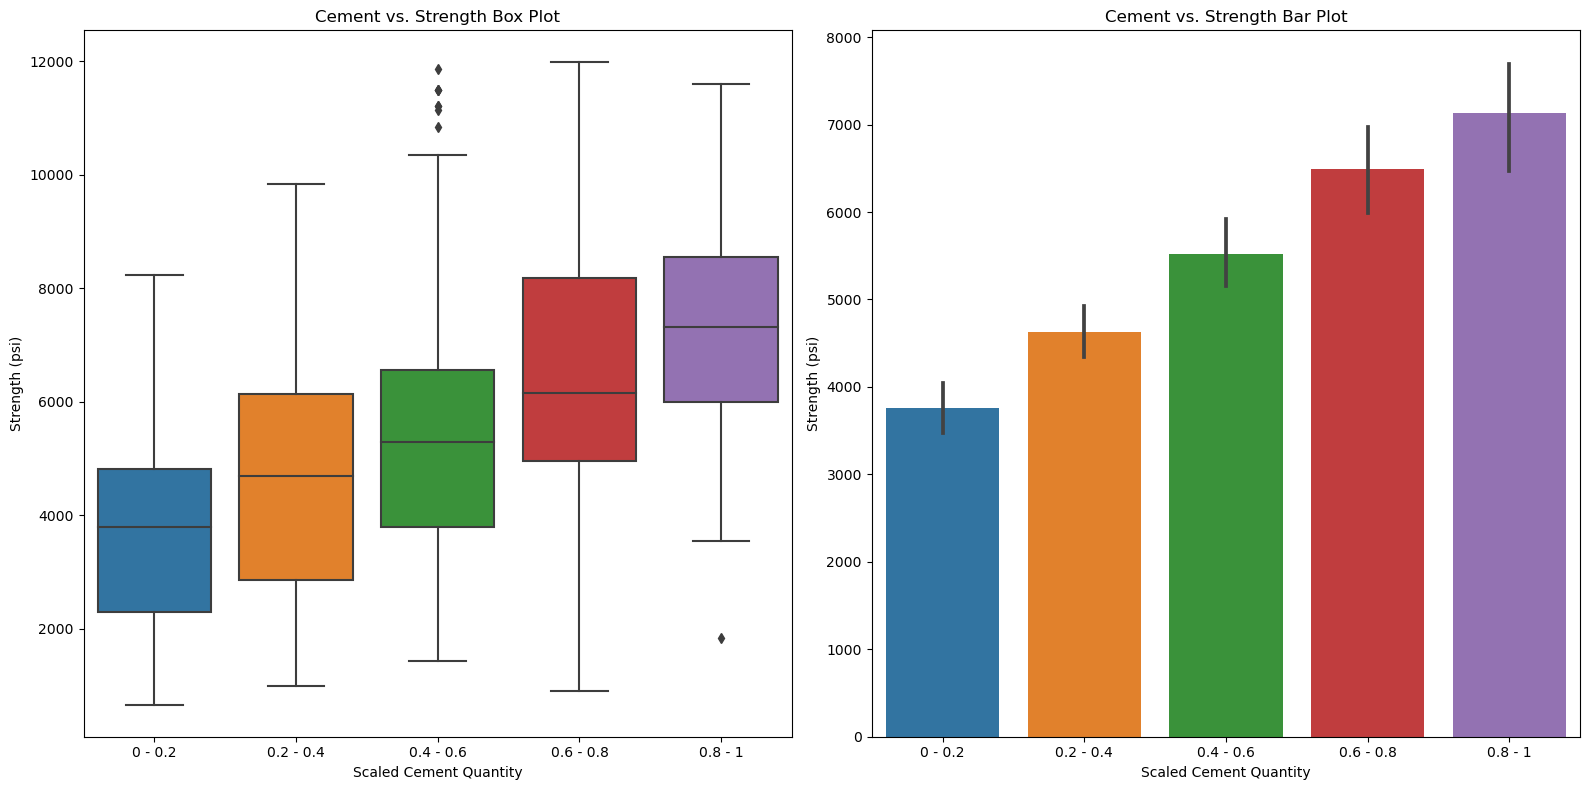

In [13]:
# boxplot and barchart
e.plot_feature_bins(train_scaled, 'cement', 'strength', bins=5, bin_labels=['0 - 0.2', '0.2 - 0.4', '0.4 - 0.6', '0.6 - 0.8', '0.8 - 1'])

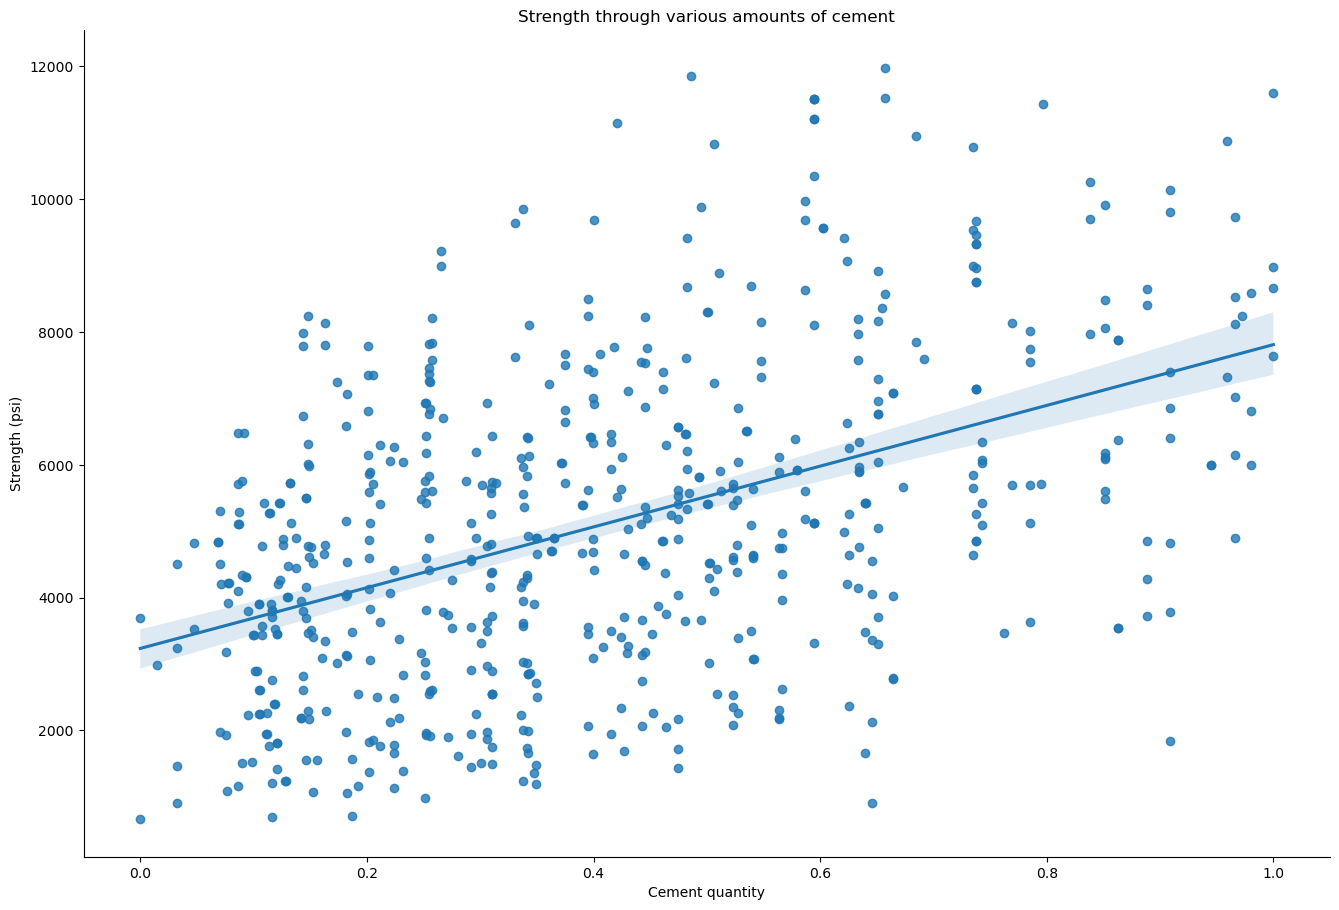

In [14]:
# plotting cement and strenght
sns.lmplot(data=train_scaled, x='cement', y='strength', markers='o', height = 9, aspect = 1.5)
plt.title('Strength through various amounts of cement')
plt.ylabel('Strength (psi)')
plt.xlabel('Cement quantity')
plt.show()

In [15]:
# Spearman's correlation between 'cement' and 'strength'
r, p = stats.spearmanr(train_scaled['cement'], train_scaled['strength'])
print('Spearman correlation between cement and strength: Correlation=%.3f, p-value=%.3f' % (r, p))

Spearman correlation between cement and strength: Correlation=0.448, p-value=0.000


In [16]:
# statistical test function
e.eval_Spearman(r,p)

We reject H₀, there is a monotonic relationship.
Spearman’s r: 0.447937
P-value: 7.878448102115859e-32


## We reject H₀, there `is` a monotonic relationship between cememt and strength

<div style="color:black; background-color: #ffffcc;">
    
  # Hypotheses:
</div>


### Q2. Is there a relationship between coarseagg and strength?

- *both of my variables are **continuous***

- check for correlation

- alpha = 0.05

$H_0$ : There is no linear correlation between coarseagg and strength

$H_a$ : There is a linear correlation between coarseagg and strength

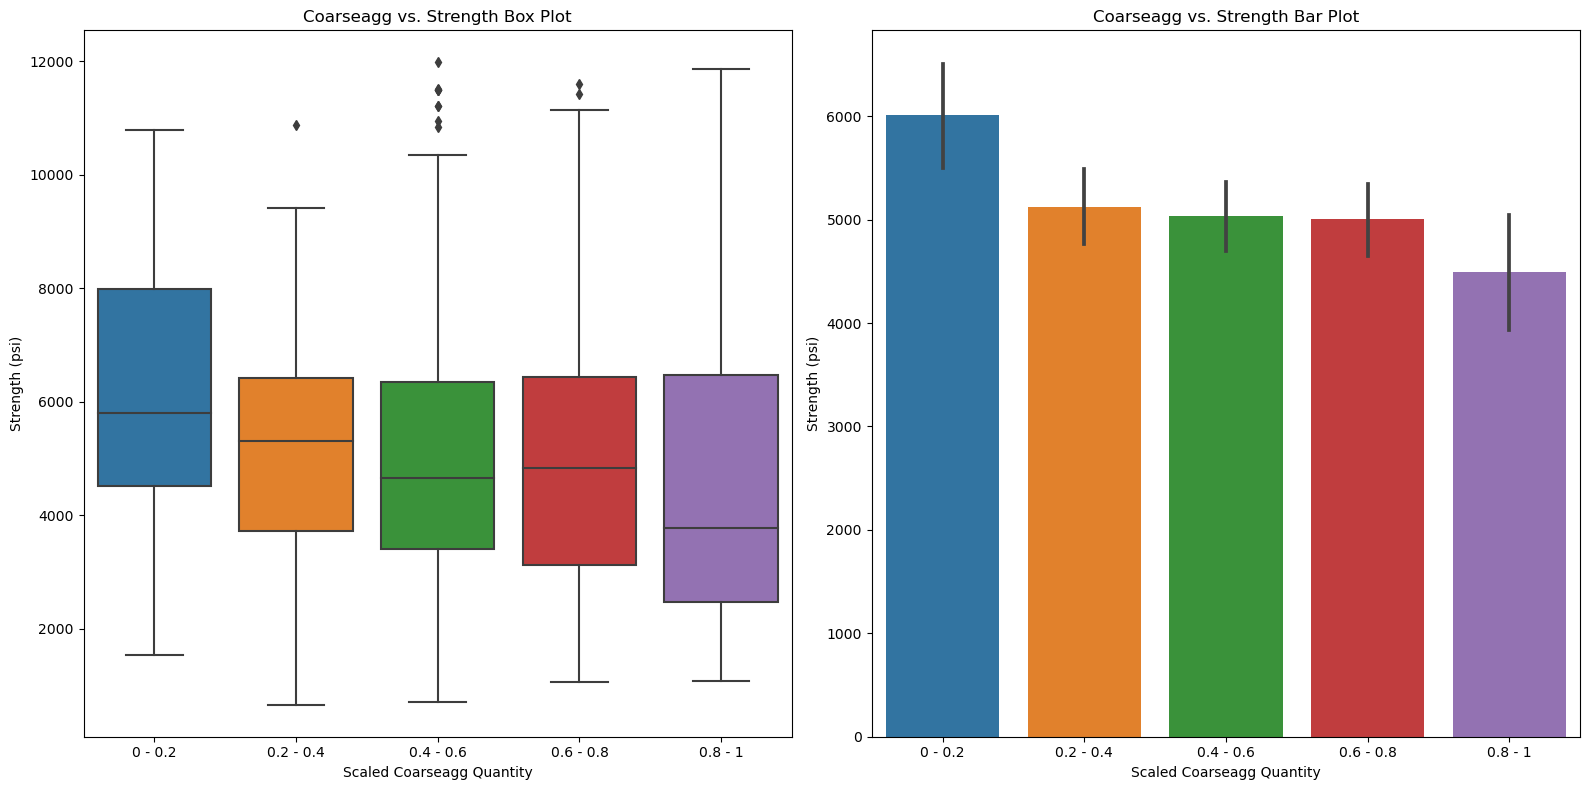

In [17]:
# boxplot and barchart
e.plot_feature_bins(train_scaled, 'coarseagg', 'strength', bins=5, bin_labels=['0 - 0.2', '0.2 - 0.4', '0.4 - 0.6', '0.6 - 0.8', '0.8 - 1'])

In [18]:
# Spearman's correlation between 'cement' and 'strength'
r, p = stats.spearmanr(train_scaled['coarseagg'], train_scaled['strength'])
print('Spearman correlation between coarseagg and strength: Correlation=%.3f, p-value=%.3f' % (r, p))

Spearman correlation between coarseagg and strength: Correlation=-0.161, p-value=0.000


In [19]:
# statistical test function
e.eval_Spearman(r,p)

We reject H₀, there is a monotonic relationship.
Spearman’s r: -0.160773
P-value: 5.949473233725961e-05


## We reject H₀, there `is` a monotonic relationship between coarseagg and strength

<div style="color:black; background-color: #ffffcc;">
    
  # Hypotheses:
</div>


### Q3. Is there a relationship between total_lbs_per_yd^3 and strength?

- *both of my variables are **continuous***

- check for correlation

- alpha = 0.05

$H_0$ : There is no linear correlation between total_lbs_per_yd^3 and strength

$H_a$ : There is a linear correlation between total_lbs_per_yd^3 and strength

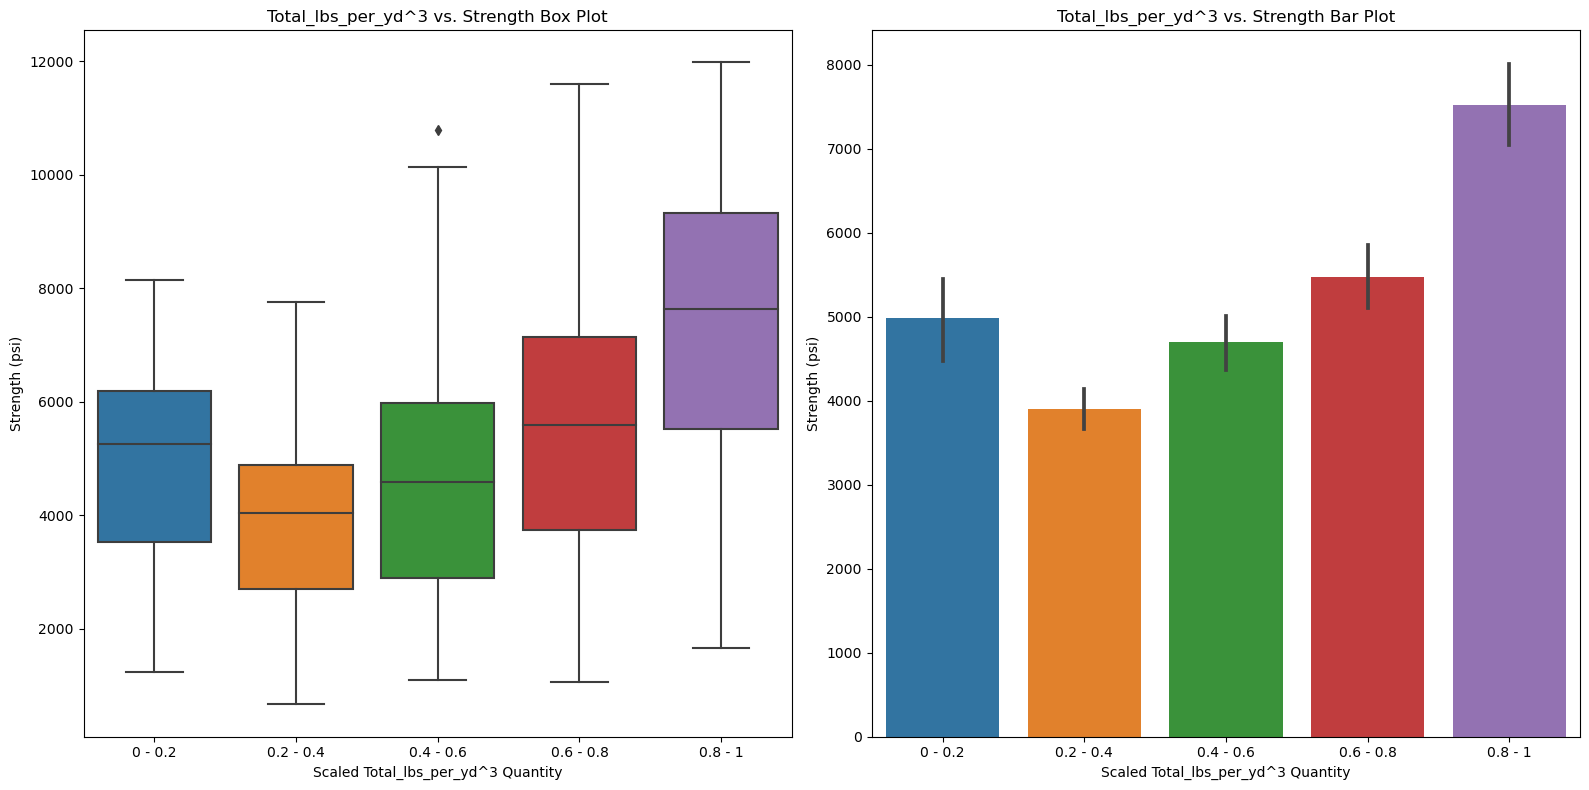

In [20]:
# boxplot and barchart
e.plot_feature_bins(train_scaled, 'total_lbs_per_yd^3', 'strength', bins=5, bin_labels=['0 - 0.2', '0.2 - 0.4', '0.4 - 0.6', '0.6 - 0.8', '0.8 - 1'])

In [21]:
# Spearman's correlation between 'cement' and 'strength'
r, p = stats.spearmanr(train_scaled['total_lbs_per_yd^3'], train_scaled['strength'])
print('Spearman correlation between total_lbs_per_yd^3 and strength: Correlation=%.3f, p-value=%.3f' % (r, p))

Spearman correlation between total_lbs_per_yd^3 and strength: Correlation=0.361, p-value=0.000


In [22]:
# statistical test function
e.eval_Spearman(r,p)

We reject H₀, there is a monotonic relationship.
Spearman’s r: 0.360755
P-value: 1.971966600003703e-20


### We reject H₀, there `is` a monotonic relationship between total_lbs_per_yd^3 and strength

<div style="color:black; background-color: #ffffcc;">
    
  # Hypotheses:</div>

### Q4. Is there a relationship between fineagg and strength?

- *both of my variables are **continuous***

- check for correlation

- alpha = 0.05

$H_0$ : There is no linear correlation between fineragg and strength

$H_a$ : There is a linear correlation between fineragg and strength



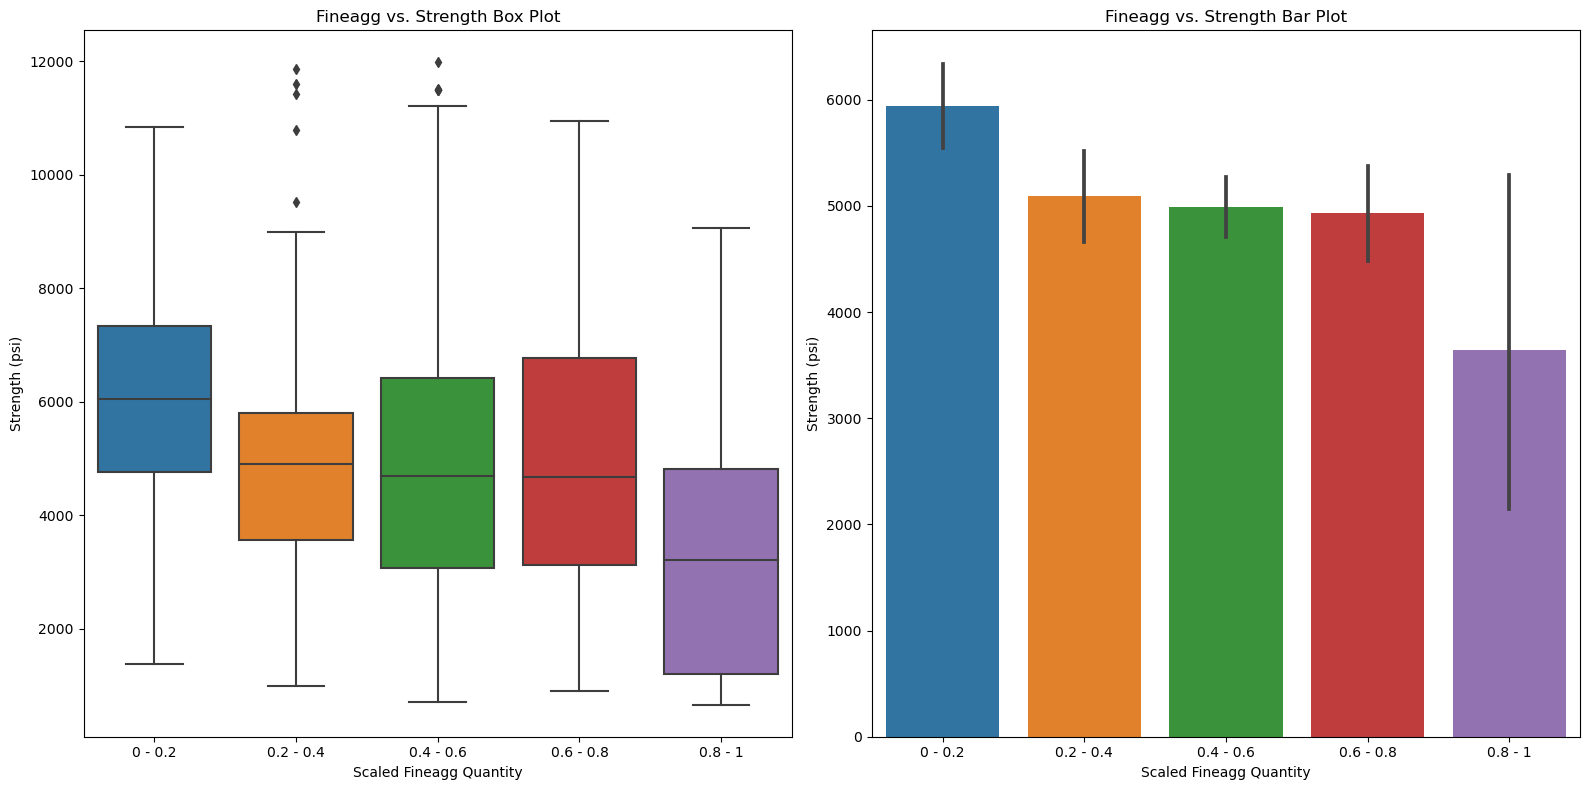

In [23]:
# boxplot and barchart
e.plot_feature_bins(train_scaled, 'fineagg', 'strength', bins=5, bin_labels=['0 - 0.2', '0.2 - 0.4', '0.4 - 0.6', '0.6 - 0.8', '0.8 - 1'])

In [24]:
# Spearman's correlation between 'cement' and 'strength'
r, p = stats.spearmanr(train_scaled['fineagg'], train_scaled['strength'])
print('Spearman correlation between fineagg and strength: Correlation=%.3f, p-value=%.3f' % (r, p))

Spearman correlation between fineagg and strength: Correlation=-0.162, p-value=0.000


In [25]:
# statistical test function
e.eval_Spearman(r,p)

We reject H₀, there is a monotonic relationship.
Spearman’s r: -0.161849
P-value: 5.298832650597833e-05


## We reject H₀, there `is` a monotonic relationship between fineagg and strength

<div style="color:black; background-color: #ffffcc;">

  # Explore summary:</div>
- `cement` has the greatest correlation with strength of concrete with an r-value of 0.45 and an alpha under 0.05.

- `total_lbs_per_yd^3` has a correlation r-value of 0.36 and an alpha under 0.05 in relation to concrete strength.

- `coarseagg` has a correlation r-value of -0.16 and an alpha under 0.05 in relation to concrete strength.

- `fineagg` has a correlation r-value of -0.16 and an alpha under 0.05 in relation to concrete strength.


In [26]:
# taking a peek at the scaled data (strenght did not get scaled as is the target)
train_scaled.head(3)

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,total_lbs_per_yd^3,strength
sample,,,,,,,,,,
600,0.399543,0.000000,0.000000,0.552716,0.000000,0.501050,0.657301,0.005495,0.3440,1647.63168
160,0.522831,0.000000,0.000000,0.560703,0.000000,0.531053,0.579528,0.074176,0.4640,4561.44510
854,0.650685,0.055648,0.469765,0.281150,0.360248,0.411041,0.629704,0.005495,0.9104,5042.97126


<div style="color:black; background-color: #ffffcc;">
    
  # **Modeling:**
  ## Baseline   
</div>

In [27]:
# Separate target column 'strength' from features
X_train = train_scaled.drop(columns='strength')
X_validate = validate_scaled.drop(columns='strength')
X_test = test_scaled.drop(columns='strength')
y_train= train_scaled[['strength']]
y_validate = validate_scaled[['strength']]
y_test = test_scaled[['strength']]

In [28]:
# simplyfing values for easier pluging into the functions
X = X_train
y = y_train

In [29]:
# run with the mean, which we saw was the better baseline previously
baseline = y.mean()
round(baseline,2)

strength    5103.33
dtype: float64

In [30]:
# making a baseline guess dataframe
# that is the same shape as the y variable:
baseline_array = np.repeat(baseline, y.shape[0])

In [31]:
# setting baseline for comparison with each model
baseline_rmse, baseline_r2 = e.evaluate_reg(y, baseline_array)
eval_df = pd.DataFrame([{
    'Train Model': 'baseline',
    'rmse': round(baseline_rmse,2),
    'r²': round(baseline_r2,4)
}])
eval_df

,Train Model,rmse,r²
0,baseline,2373.7,0.0


In [32]:
# setting baseline for validation comparison
val_dict = pd.DataFrame([{
    'Val Model': 'baseline',
    'Val rmse': round(baseline_rmse,2),
    'Val r²': round(baseline_r2,4)
}])

val_dict

,Val Model,Val rmse,Val r²
0,baseline,2373.7,0.0


<div style="color:black; background-color: #ffffcc;">

  ## Model: Ordinary Least Squares (OLS)
</div>

In [33]:
# initial ML model
lr1 = LinearRegression()

# rfe has entered the chat:
rfe3 = RFE(lr1, n_features_to_select=3)

# fit
rfe3.fit(X, y)

# transform
X_train_rfe3 = rfe3.transform(X)

X_val_rfe3 = rfe3.transform(X_validate)

X_test_rfe3 = rfe3.transform(X_test)

In [34]:
# feature that it selected?
rfe3.get_feature_names_out()

array(['coarseagg', 'fineagg', 'total_lbs_per_yd^3'], dtype=object)

In [35]:
# lr1 as an object was created for our RFE process,
# lets just use that same object for our first model
lr1.fit(X_train_rfe3, y)

LinearRegression()

In [36]:
# adding ols train results to eval dict
rmse, r_2 = e.evaluate_reg(y, lr1.predict(X_train_rfe3))
eval_df = pd.concat([eval_df, pd.DataFrame(
[
    {
        'Train Model': 'ols_rfe_3',
        'rmse': rmse,
        'r²': r_2
    }
])], ignore_index=True, axis=0)
eval_df

,Train Model,rmse,r²
0,baseline,2373.700000,0.000000
1,ols_rfe_3,1891.601542,0.364951


In [37]:
# adding to val model list
val_rmse, val_r2 = e.evaluate_reg(y_validate, lr1.predict(X_val_rfe3))
val_dict = pd.concat([val_dict, pd.DataFrame([({
    'Val Model': 'ols_rfe_3',
    'Val rmse': val_rmse,
    'Val r²': val_r2
})])], ignore_index=True, axis=0)
val_dict

,Val Model,Val rmse,Val r²
0,baseline,2373.700000,0.000000
1,ols_rfe_3,1757.380057,0.505661


<div style="color:black; background-color: #ffffcc;">
    
  ## Model: Polynomial Regression
</div>


In [38]:
# Step 1: Select desired features
selected_features = ['coarseagg', 'fineagg', 'total_lbs_per_yd^3']
X_train_selected = X_train[selected_features]
X_validate_selected = X_validate[selected_features]
X_test_selected = X_test[selected_features]

In [39]:
# Step 2: Apply polynomial transformation
pf3 = PolynomialFeatures(degree=3)

# Fit on training set and transform the selected features
x_train_sq_selected = pf3.fit_transform(X_train_selected)

# Transform the selected features for validation and test sets
x_val_sq_selected = pf3.transform(X_validate_selected)
x_test_sq_selected = pf3.transform(X_test_selected)

In [40]:
# Step 3: Fit the model to the transformed features
plyreg3 = LinearRegression()
plyreg3.fit(x_train_sq_selected, y_train)

# Now you can use plyreg3 to make predictions and evaluate the model
# For instance, to evaluate on the validation set:
y_val_pred = plyreg3.predict(x_val_sq_selected)

In [41]:
# concating on val_dict to add another model on train
rmse, r_2 = e.evaluate_reg(y_train, plyreg3.predict(x_train_sq_selected))
eval_df = pd.concat([eval_df, pd.DataFrame(
[
    {
        'Train Model': 'quad_reg3.3',
        'rmse': rmse,
        'r²': r_2
    }
])], ignore_index=True, axis=0)
eval_df

,Train Model,rmse,r²
0,baseline,2373.700000,0.000000
1,ols_rfe_3,1891.601542,0.364951
2,quad_reg3.3,1778.313463,0.438740


In [42]:
# concating on val_dict to add another model on validate
val_rmse, val_r2 = e.evaluate_reg(y_validate, plyreg3.predict(x_val_sq_selected))
val_dict = pd.concat([val_dict, pd.DataFrame([({
    'Val Model': 'quad_reg3.3',
    'Val rmse': val_rmse,
    'Val r²': val_r2
})])], ignore_index=True, axis=0)
val_dict

,Val Model,Val rmse,Val r²
0,baseline,2373.700000,0.000000
1,ols_rfe_3,1757.380057,0.505661
2,quad_reg3.3,1826.639054,0.465929


<div style="color:black; background-color: #ffffcc;">
  
  ## Model: LassoLars</div>

In [43]:
# Step 1: Select desired features
selected_features = ['coarseagg', 'fineagg', 'total_lbs_per_yd^3']
X_train_selected = X_train[selected_features]

# Step 2: Fit the LassoLars model to the selected features
lasso = LassoLars(alpha=1)
lasso.fit(X_train_selected, y_train)

LassoLars(alpha=1)

In [44]:
# Selecting the same features from the validation and test sets
X_validate_selected = X_validate[selected_features]
X_test_selected = X_test[selected_features]

# Now you can use the trained model to predict and evaluate on the validation and test sets
y_val_pred = lasso.predict(X_validate_selected)
y_test_pred = lasso.predict(X_test_selected)

In [45]:
# adding lasso to train model dict
rmse, r_2 = e.evaluate_reg(y_train, lasso.predict(X_train_selected))
eval_df = pd.concat([eval_df, pd.DataFrame(
[
    {
        'Train Model': 'lasso.3',
        'rmse': rmse,
        'r²': r_2
    }
])], ignore_index=True, axis=0)
eval_df

,Train Model,rmse,r²
0,baseline,2373.700000,0.000000
1,ols_rfe_3,1891.601542,0.364951
2,quad_reg3.3,1778.313463,0.438740
3,lasso.3,1891.634055,0.364930


In [46]:
# concating on val_dict to add another model on validate
val_rmse, val_r2 = e.evaluate_reg(y_validate, lasso.predict(X_validate_selected))
val_dict = pd.concat([val_dict, pd.DataFrame([({
    'Val Model': 'lasso.3',
    'Val rmse': val_rmse,
    'Val r²': val_r2
})])], ignore_index=True, axis=0)
val_dict

,Val Model,Val rmse,Val r²
0,baseline,2373.700000,0.000000
1,ols_rfe_3,1757.380057,0.505661
2,quad_reg3.3,1826.639054,0.465929
3,lasso.3,1759.978848,0.504197


<div style="color:black; background-color: #ffffcc;">
  
  ## Plotting Residuals for each model</div>

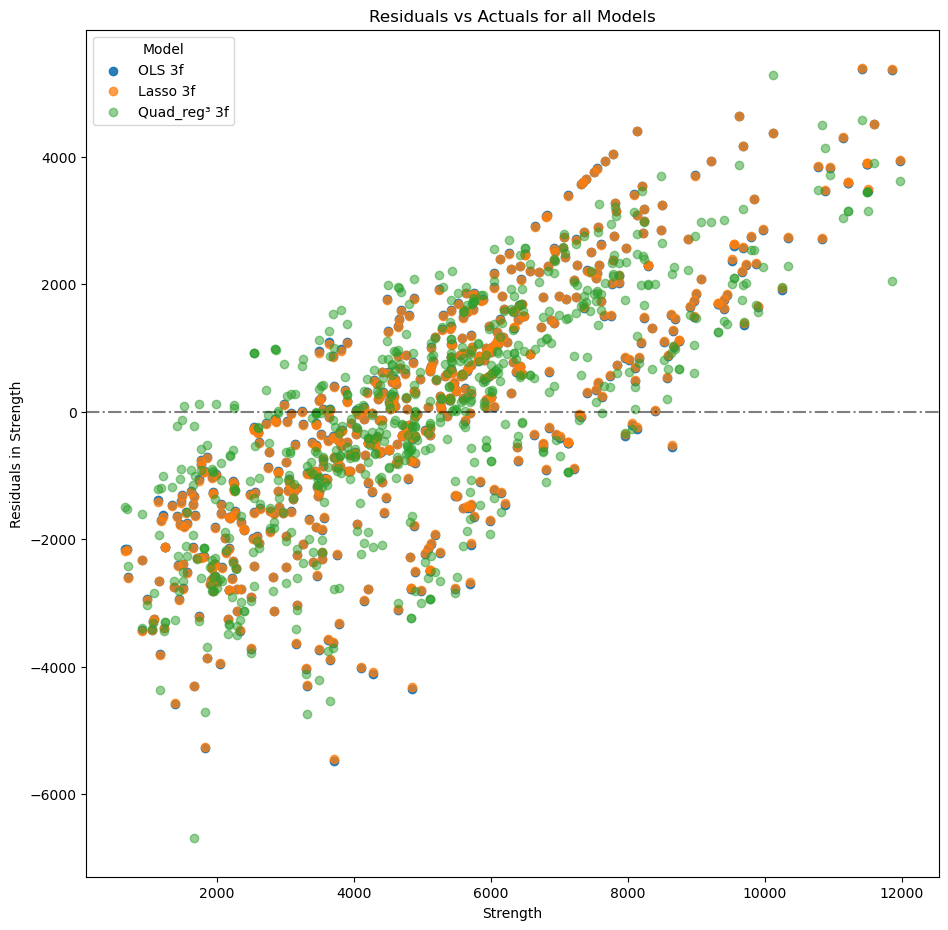

In [47]:
# Convert y to a numpy array for consistent operations
y_array = y.values.ravel()  # This flattens y to a 1D numpy array

# Now plotting
plt.figure(figsize=(11, 11))
plt.scatter(y, y - lr1.predict(X_train_rfe3), label='OLS 3f', alpha=0.95)
plt.scatter(y_train, y_array - lasso.predict(X_train_selected), label='Lasso 3f', alpha=0.75)
plt.scatter(y_train, y - plyreg3.predict(x_train_sq_selected), label='Quad_reg³ 3f', alpha=0.5)
plt.title('Residuals vs Actuals for all Models')
plt.axhline(0, ls='-.', c='k', alpha=0.5)
plt.ylabel('Residuals in Strength')
plt.xlabel('Strength')
plt.legend(title='Model')
plt.show()


<div style="color:black; background-color: #ffffcc;">
  
  ## Test Model: Ploynomial Regression to the power of 3</div>

In [48]:
# setting baseline for validation comparison
test_dict = pd.DataFrame([{
    'Test Model': 'baseline',
    'Test rmse': round(baseline_rmse,2),
    'Test r²': round(baseline_r2,4)
}])
# concating on val_dict to add another model on validate
test_rmse, test_r2 = e.evaluate_reg(y_test, plyreg3.predict(x_test_sq_selected))
test_dict = pd.concat([test_dict, pd.DataFrame([({
    'Test Model': 'quad_reg3.3',
    'Test rmse': test_rmse,
    'Test r²': test_r2
})])], ignore_index=True, axis=0)

test_dict

,Test Model,Test rmse,Test r²
0,baseline,2373.700000,0.000000
1,quad_reg3.3,1784.105793,0.479165


In [49]:
# Improved display of results using DataFrame
results_df = pd.DataFrame({
    'Model': ['Baseline', 'Train', 'Validate', 'Test'],
    'RMSE': [2373.7, 1778.31, 1826.63, 1784.10],
    'R^2': [0.0, 0.43874, 0.46593, 0.47916]
})
display(results_df.set_index('Model'))


,RMSE,R^2
Model,,
Baseline,2373.70,0.00000
Train,1778.31,0.43874
Validate,1826.63,0.46593
Test,1784.10,0.47916


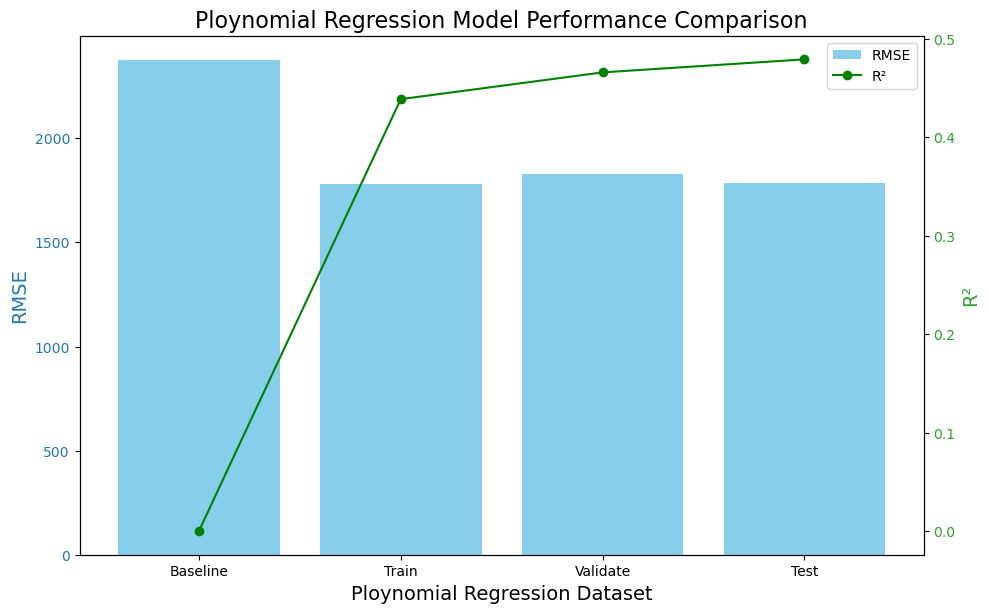

In [50]:
#usage of the function in explore:
models = ['Baseline', 'Train', 'Validate', 'Test']
rmse_values = [2373.7, 1778.31, 1826.63, 1784.10]
r_squared_values = [0.0, 0.43874, 0.46593, 0.47916]

e.plot_performance(models, rmse_values, r_squared_values)

<div style="color:black; background-color: #ffffcc;">
  
  ## Modeling Wrap</div>

- With the Polynomial Regression model: rmse on test sample was 1784.10, as opposed to baseline 2373.70 (25% better than baseline).
- With the Polynomial Regression model: r² significantly inclreased to almost 50%
- Use the model as a better estimator of concrete strength compared to baseline.

<div style="color:black; background-color: #ffffcc;">
  
  # **Conclusion**</div>

<div style="color:black; background-color: #ffffcc;"> 
  
  ## Summary</div>
#### - The Polynomial Regression model significantly outperforms the baseline, explaining up to 47.92% of the variance in concrete strength.
#### - With 'total_lbs_per_yd^3' positively correlated and 'coarseagg' and 'fineagg' negatively correlated with strength, all significant at an alpha below 0.05.

<div style="color:black; background-color: #ffffcc;">
    
  ## Recommendations</div>
#### - Stakeholders should prioritize optimizing the total mix composition, particularly focusing on the 'total_lbs_per_yd^3' due to its strong positive impact on strength.
#### - A deeper analysis of 'coarseagg' and 'fineagg' proportions is advised to enhance the concrete's strength further.

<div style="color:black; background-color: #ffffcc;">
    
  ## Next Steps</div>
#### - Explore additional features or transformations that might better capture the relationships in the data, such as interaction terms between different types of aggregates.
